In [98]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [38]:
#importing all files
nyc = pd.read_csv('vaccine-data/nyc.csv')
houston = pd.read_csv('vaccine-data/Houston.csv')
la = pd.read_csv('vaccine-data/la.csv')
chicago = pd.read_csv('vaccine-data/chicago.csv')

## Data Cleaning

After importing all the separate data, I am going through to make sure each has a consistent format including date range and column name for the target variable. I also am labeling each city within the dataframe for when I merge them. 

In [39]:
# starting with new york

nyc['city'] = 'new york'  # adding location column
nyc['date'] = pd.to_datetime(nyc['DATE'])  # converting dates to datetime

new_nyc = nyc[nyc['date'] >= '2021-01-01']  # filtering to consistent timeframe

# getting consistent column name for vaccines administered
new_nyc['total_doses'] = new_nyc['ADMIN_ALLDOSES_DAILY']

In [40]:
# repeating steps with houston

houston['date'] = pd.to_datetime(houston['Date_str'])

# filtering to consistent timeframe
new_houston = houston[(houston['date'] >= '2021-01-01')
                      & (houston['date'] <= '2021-06-15')]

# getting consistent column name for vaccines administered
new_houston['total_doses'] = new_houston['Vaccinated']

# need to do a groupby since there are multiple readings from each date
new_houston = new_houston.groupby(['date'], as_index=False).sum()
new_houston['city'] = 'houston'  # adding location column

In [41]:
#also need to difference the data as it is cumulative
new_houston['total_doses'] = new_houston['total_doses'].diff()

In [42]:
#chicago
chicago['city'] = 'chicago'
chicago['date'] = pd.to_datetime(chicago['Date'])
chicago['total_doses'] = chicago['Total Doses - Daily']
new_chicago = chicago[chicago['date'] >= '2021-01-01']

In [43]:
#los angeles, also need to group by date
la['date'] = pd.to_datetime(la['Date (Dose 1)'])
new_la = la[la['date'] >= '2021-01-01']
new_la = new_la.groupby(['date'], as_index=False).sum()
new_la['city'] = 'los angeles'
new_la['total_doses'] = new_la['Dose1_all']

I'm writing a function to run each dataframe through to format with only the columns I want. Then I'll look at the data overall.

In [44]:
def to_merge(dataframe):
    city_subset = dataframe[['date', 'city', 'total_doses']]
    return(city_subset)

In [45]:
nyc_merge = to_merge(new_nyc)
houston_merge  = to_merge(new_houston)
chicago_merge  = to_merge(new_chicago)
la_merge  = to_merge(new_la)

In [46]:
#combining dataframes
combined = pd.concat([nyc_merge, houston_merge, chicago_merge, la_merge],
                     ignore_index=True, sort=False).sort_values(by='date')

time_indexed_combined = combined.set_index('date')

time_indexed_combined.head()

,city,total_doses
date,,
2021-01-01,new york,167.0
2021-01-01,houston,NaN
2021-01-01,los angeles,1112.0
2021-01-01,chicago,48.0
2021-01-02,houston,2737.0


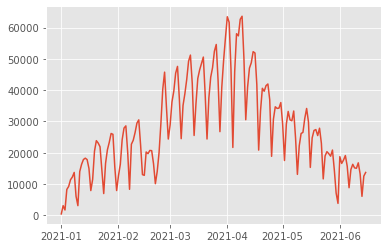

In [47]:
ti_mean = time_indexed_combined.groupby('date').mean()
plt.plot(ti_mean)

## Creating Time Series 

Now that I've cleaned and inspected the data, I'm going to format each city's dataframe for time series modeling.

Looking at the chart below, I can get an idea of how the volume of vaccinations differ from place to place, where New York City is seeing a much higher volume than Houston overall. 

In [48]:
nyc_ts = nyc_merge.set_index('date')['total_doses']
hou_ts = houston_merge.set_index('date')['total_doses']
chi_ts = chicago_merge.set_index('date')['total_doses']
la_ts = la_merge.set_index('date')['total_doses']

In [69]:
#due to the groupby there is 1 null in the houston data
hou_ts.dropna(inplace=True)

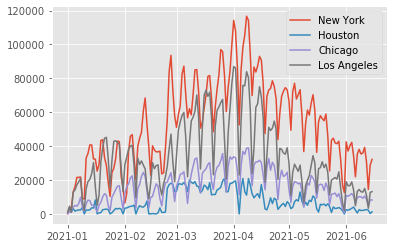

In [70]:
plt.plot(nyc_ts, label='New York')
plt.plot(hou_ts, label='Houston')
plt.plot(chi_ts, label='Chicago')
plt.plot(la_ts, label='Los Angeles')
plt.legend()

## Checking for Trends

In each city there appear to be periodic trends, which would violate the assumption of stationarity that I'd need for a time series model to be effective. Below I am going to run a test to check if my data is stationary.

The function below will compare the rolling mean and standard deviation of each city for a visual of the trends. Next I'm going to use the Dickey-Fuller test. If the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary.

In [75]:
def stationarity_plot(data, city):
    
    roll_mean = data.rolling(window=8, center=False).mean()
    roll_std = data.rolling(window=8, center=False).std()
    
    dftest = adfuller(data)

    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(city))
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test for {}: \n'.format(city))

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

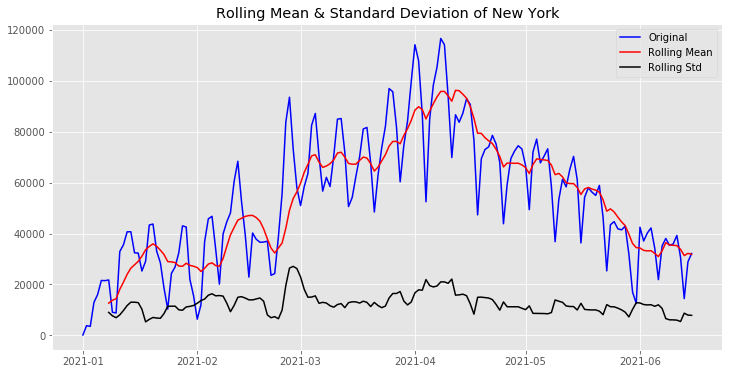

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -1.198953
p-value                          0.674046
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


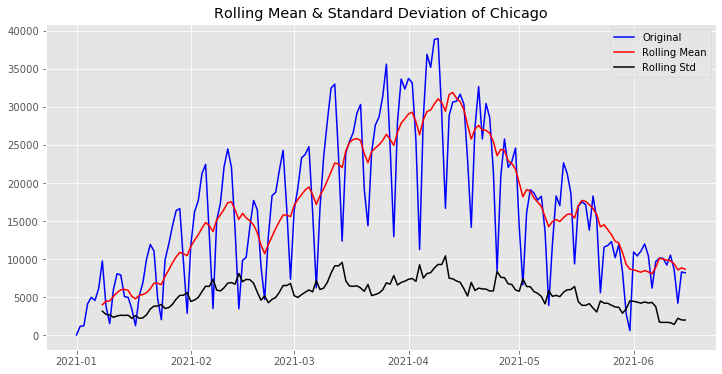

Results of Dickey-Fuller Test for Chicago: 

Test Statistic                  -1.712065
p-value                          0.424907
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


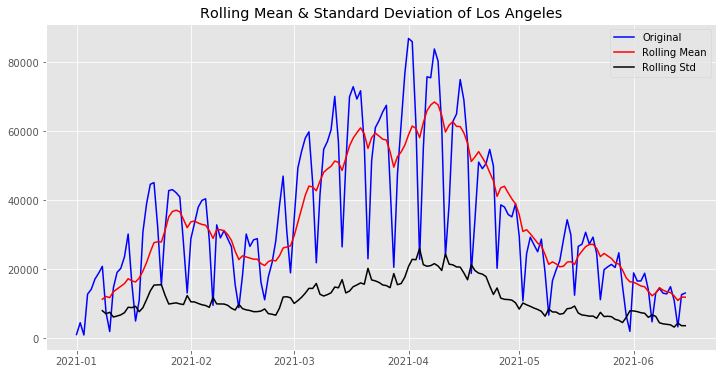

Results of Dickey-Fuller Test for Los Angeles: 

Test Statistic                  -1.547956
p-value                          0.509669
#Lags Used                       8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


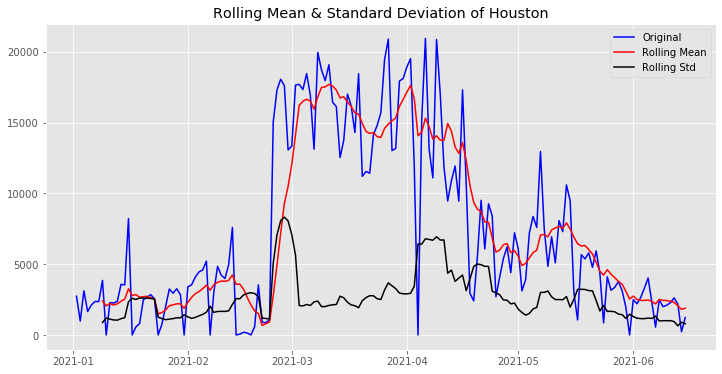

Results of Dickey-Fuller Test for Houston: 

Test Statistic                  -1.540347
p-value                          0.513466
#Lags Used                       7.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [76]:
stationarity_plot(nyc_ts, 'New York')
stationarity_plot(chi_ts, 'Chicago')
stationarity_plot(la_ts, 'Los Angeles')
stationarity_plot(hou_ts, 'Houston')

Results uphold the null hypothesis: the time series is not stationary for any of the cities. So I need to look into removing trends.

To determine the best way to transform the data, I'm going to look at 2 different visuals: log transformations and square root transformations.

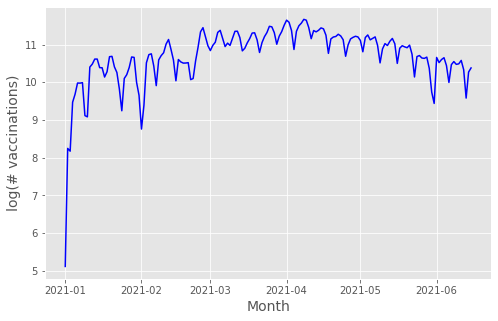

In [85]:
#log transformation

nyc_ts_log = np.log(nyc_ts)

fig = plt.figure(figsize=(8,5))
plt.plot(nyc_ts_log, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(# vaccinations)', fontsize=14)

plt.show()

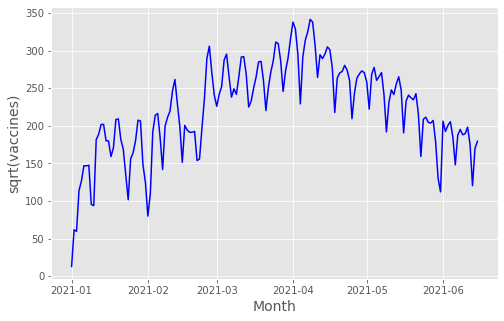

In [86]:
# Plot a square root transform
nyc_data_sqrt = np.sqrt(nyc_ts)

fig = plt.figure(figsize=(8,5))
plt.plot(nyc_data_sqrt, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('sqrt(vaccines)', fontsize=14)
plt.show()

The log transformation looks more effective at removing trends, where the sqrt transformation looks similar to the original trends in the data.

To proceed, I'm going to get a rolling mean of the log transformed data, and  subtract it from the log data

In [87]:
roll_mean_nyc = nyc_ts_log.rolling(window=7).mean()

# Subtract the moving average from the log transformed data
data_minus_roll_mean = nyc_ts_log - roll_mean_nyc

# Print the first 10 rows
data_minus_roll_mean.head()

date
2021-01-01   NaN
2021-01-02   NaN
2021-01-03   NaN
2021-01-04   NaN
2021-01-05   NaN
Name: total_doses, dtype: float64

In [88]:
data_minus_roll_mean.dropna(inplace=True)

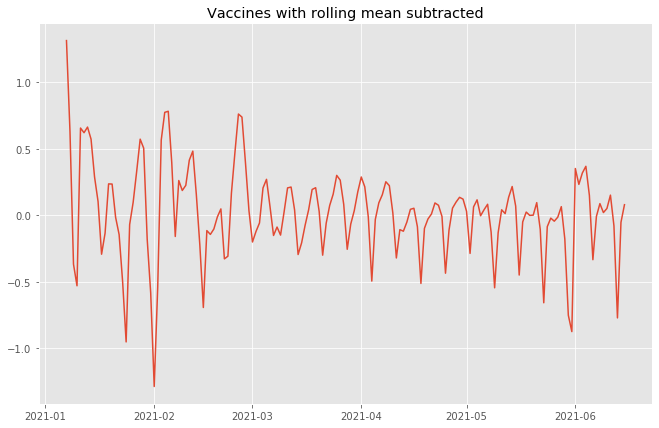

In [90]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean)
plt.title('Vaccines with rolling mean subtracted')
plt.show(block=False)

This already looks better so I'm going to check again for stationarity.


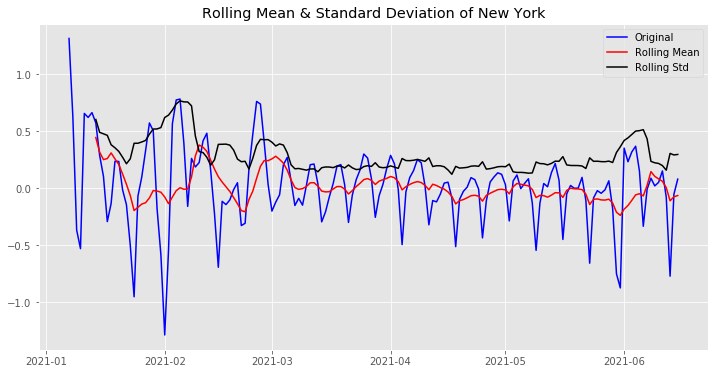

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -3.878451
p-value                          0.002199
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


In [91]:
stationarity_plot(data_minus_roll_mean, 'New York')

It looks like the NYC data has just made it.

In [ ]:
## Differencing?

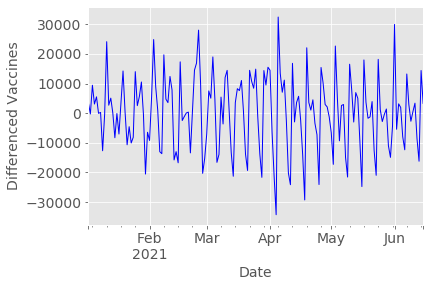

In [97]:
nyc_diff = nyc_ts.diff()
nyc_diff.dropna(inplace=True)
nyc_diff.plot(color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Vaccines', fontsize=14);

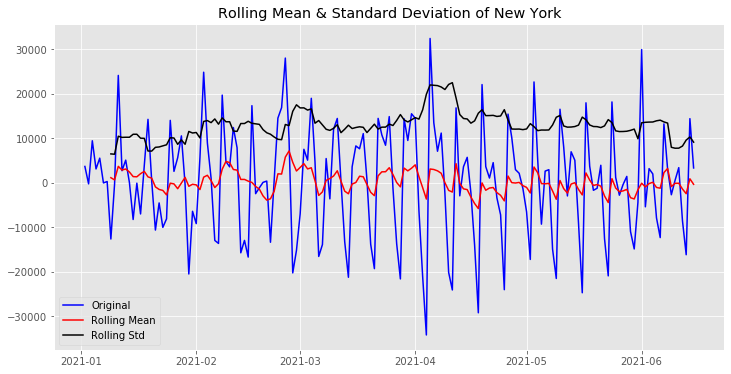

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -3.302042
p-value                          0.014787
#Lags Used                      13.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [96]:
stationarity_plot(nyc_diff, 'New York')

In [ ]:
# decompose?

## Time Series Modeling

In [99]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [101]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_minus_roll_mean,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =101.22955063737774
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =61.58230277227498
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =227.73967656963663
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =101.57813509921547
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =73.63228368471755
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =61.85105133679268
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =165.95738377716805
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =102.23378504275496
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =38.47292929700345
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =18.686424210644887
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =153.2232436321525
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =40.28272482069962
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =23.261396113950553
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =14.091724966532842
ARIMA (0, 0,

In [102]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (1, 0, 1, 12)
aic            11.967
Name: 45, dtype: object

In [103]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_minus_roll_mean, 
                                        order=(1, 0, 1), 
                                        seasonal_order=(1, 0, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2739      0.106      2.594      0.009       0.067       0.481
ma.L1          0.3603      0.132      2.720      0.007       0.101       0.620
ar.S.L12       0.3870      0.093      4.162      0.000       0.205       0.569
ma.S.L12      -0.8760      0.140     -6.246      0.000      -1.151      -0.601
sigma2         0.0527      0.007      7.391      0.000       0.039       0.067


The first 3/5 features have p values > than 0.05 so we can't consider them significant

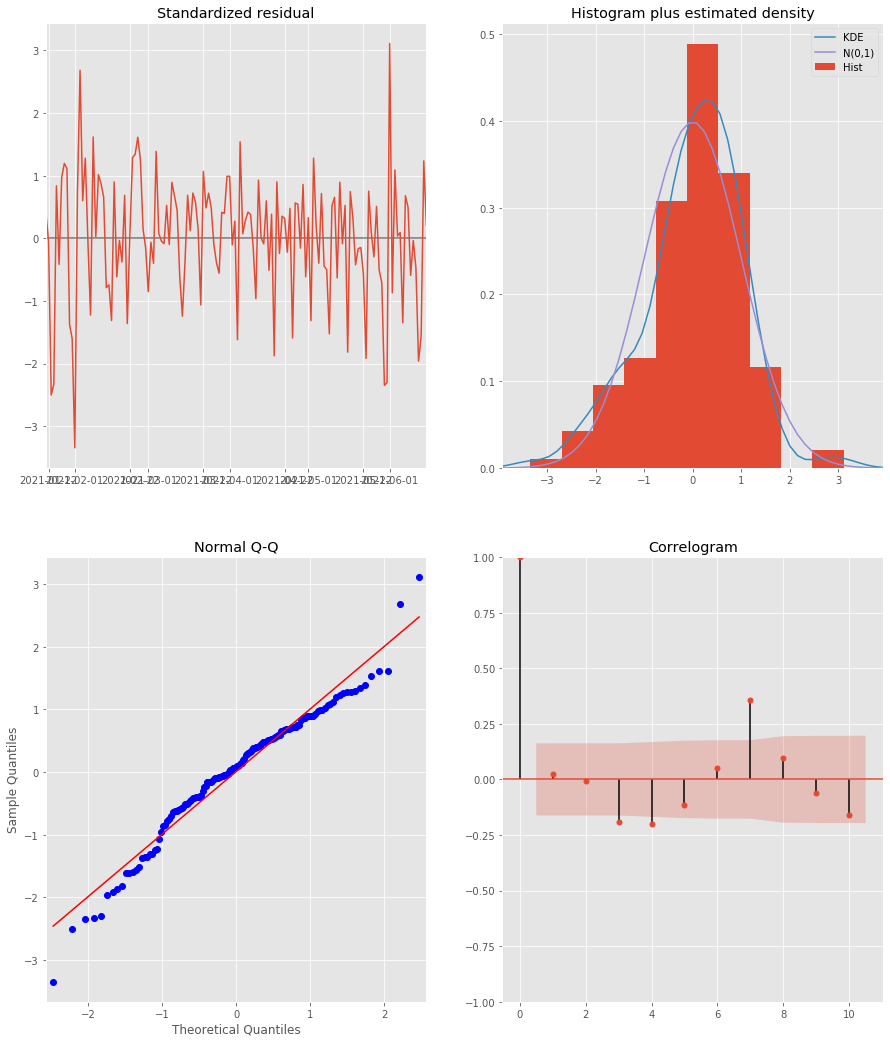

In [104]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

ex evaluation

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## validating the model

In [117]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-07'), dynamic=False)
pred_conf = pred.conf_int()

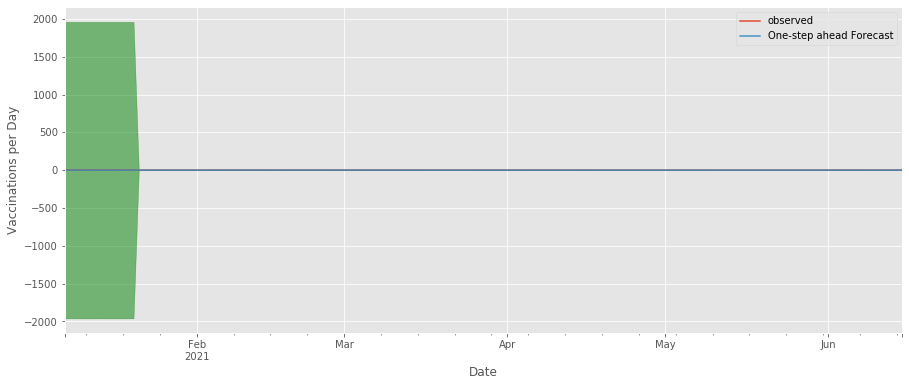

In [118]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = data_minus_roll_mean['2021':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Vaccinations per Day')
plt.legend()

plt.show()

In [119]:
# Get the real and predicted values
forecasted = pred.predicted_mean
true = nyc_ts['2021-01-07':]

# Compute the mean square error
mse = ((forecasted - true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3575572898.52


In [121]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2021-01-07'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

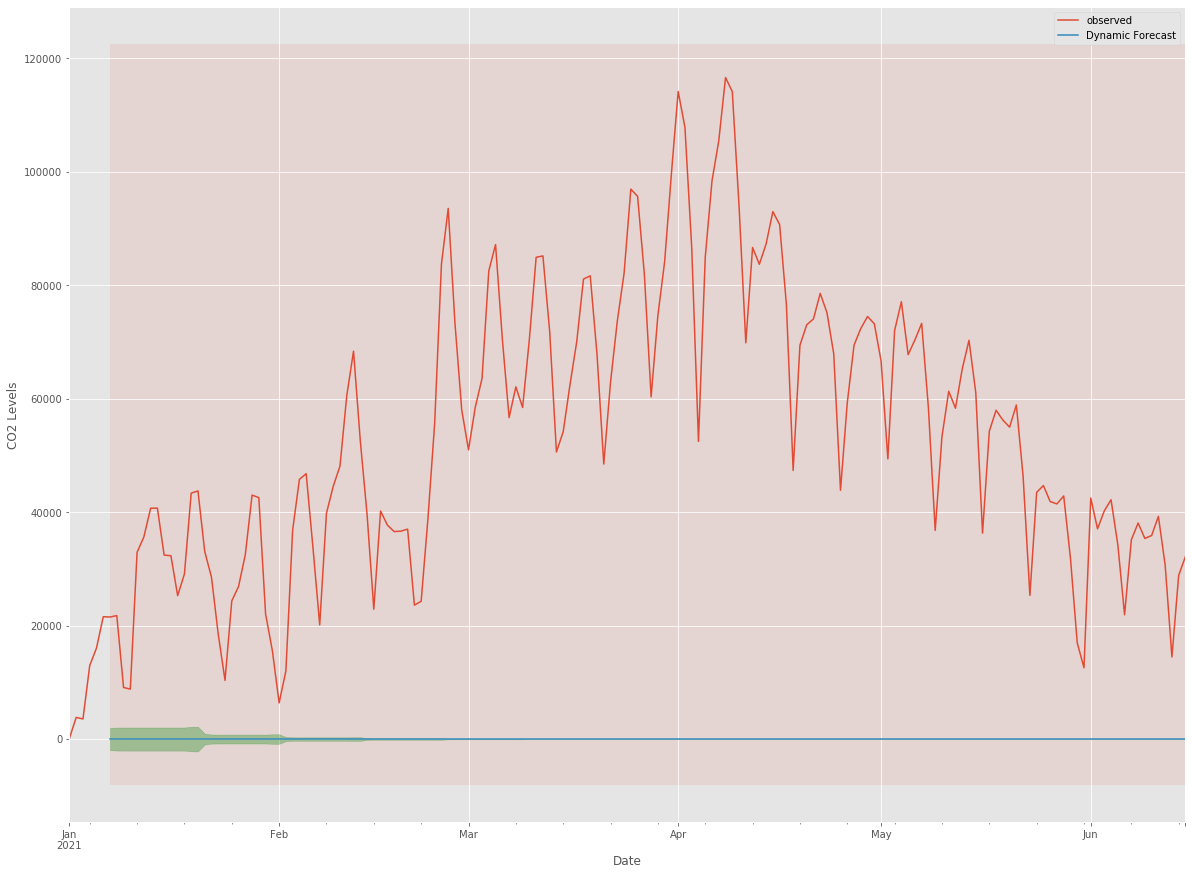

In [122]:
# Plot the dynamic forecast with confidence intervals.

ax = nyc_ts['2021':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-07'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [58]:
# Get the real and predicted values
forecasted = pred_dynamic.predicted_mean
true = nyc_ts['2021-01-01':]

# Compute the mean square error
mse = ((forecasted - true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3451870072.4


In [61]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

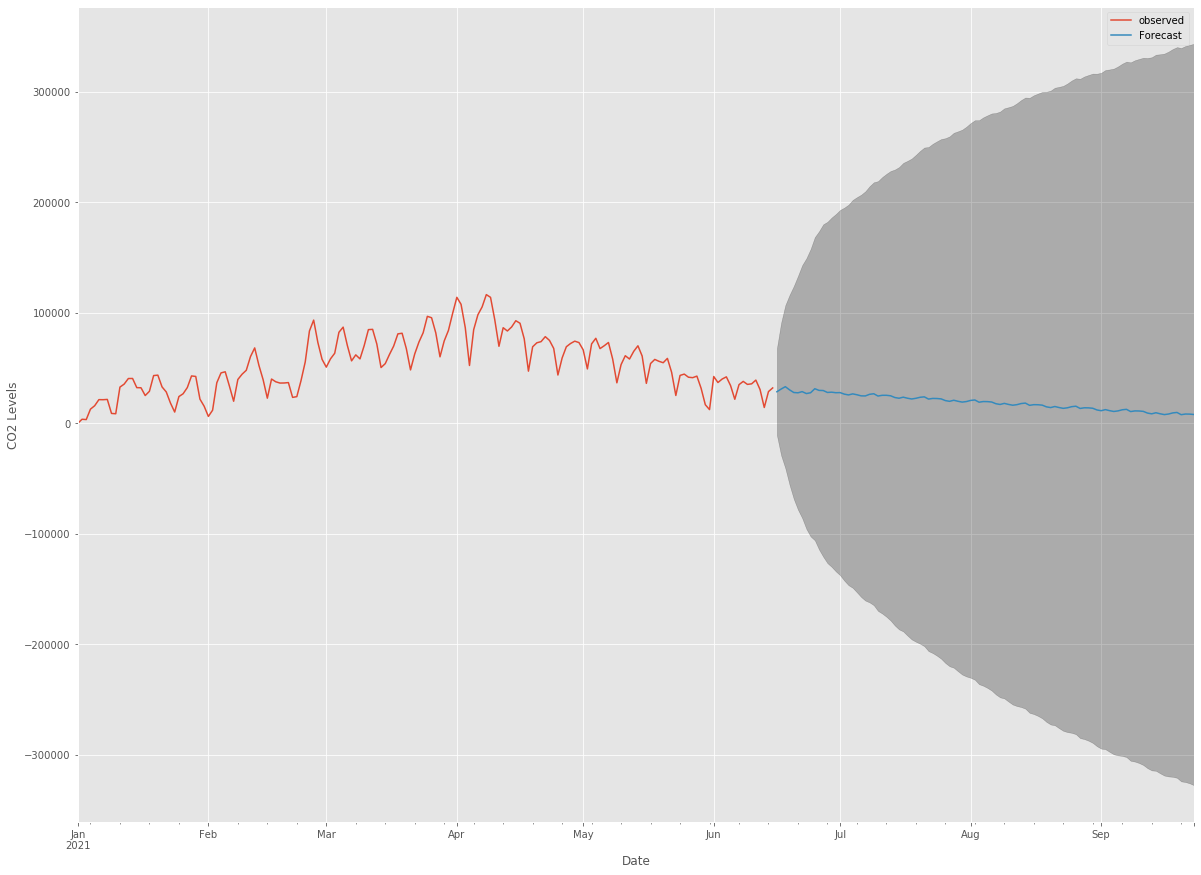

In [62]:
# Plot future predictions with confidence intervals
ax = nyc_ts.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()